In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from seaborn import set_style
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from mpl_toolkits import mplot3d
set_style("whitegrid")
import re

In [2]:
clTrials = pd.read_csv("CancerClinicalTrialData.csv")

In [3]:
clTrials

,Rank,Title,Status,Study Results,Conditions,Interventions,Outcome Measures,Gender,Age,Phases,Enrollment,Funded Bys,Study Designs,Start Date,Completion Date,Study Duration (months),Locations,URL
0,1,Immediate-Release Oxycodone Capsules Study in ...,Completed,Has Results,Cancer,Drug: Oxycodone|Drug: Morphine,Numerical Rating Scale (NRS)|The Average Dose ...,All,"18 Years to 80 Years (Adult, Older Adult)",Phase 3,242,Industry,Allocation: Randomized|Intervention Model: Par...,Jan-11,Jul-12,18,NaN,https://ClinicalTrials.gov/show/NCT01675622
1,2,A Phase II Study of Nivolumab in Combination W...,Completed,Has Results,Breast Cancer,Drug: Nivolumab|Drug: Cabozantinib,Overall Response Rate|Number of Participants W...,Female,"18 Years and older (Adult, Older Adult)",Phase 2,18,Other|Industry,Allocation: N/A|Intervention Model: Single Gro...,30-Nov-17,30-Aug-19,21,"Dana-Farber Cancer Institute, Boston, Massachu...",https://ClinicalTrials.gov/show/NCT03316586
2,3,"Radiation, Cetuximab and Pemetrexed With or Wi...",Completed,Has Results,Cancer,Drug: Bevacizumab|Drug: Cetuximab|Drug: Pemetr...,2-year Progression-free Survival (PFS)|2-year ...,All,"18 Years and older (Adult, Older Adult)",Phase 2,80,Other|Industry,Allocation: Randomized|Intervention Model: Sin...,Oct-08,Sep-14,71,"University of Pittsburgh Medical Center, Pitts...",https://ClinicalTrials.gov/show/NCT00703976
3,4,Fulvestrant Plus Enzalutamide in ER+/Her2- Adv...,Completed,Has Results,Breast Cancer,Drug: Fulvestrant with Enzalutamide,Clinical Benefit Rate of the Combination of En...,Female,"18 Years to 100 Years (Adult, Older Adult)",Phase 2,32,Other|U.S. Fed,Allocation: N/A|Intervention Model: Single Gro...,6-Jul-17,10-Apr-20,33,"University of Colorado, Aurora, Colorado, Unit...",https://ClinicalTrials.gov/show/NCT02953860
4,5,PROspective Non-interventional Open laBEl Tria...,Completed,Has Results,Cancer,Drug: Oxycodone/Naloxone,Change in Numeric Rating Scales (NRS) Score|Ch...,All,"20 Years and older (Adult, Older Adult)",Phase 4,359,Industry,Allocation: N/A|Intervention Model: Single Gro...,Jul-12,Apr-14,21,13 sites including Yeungnam University Medical...,https://ClinicalTrials.gov/show/NCT01719757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11191,11192,Safety and Efficacy of ATIR101 as Adjunctive T...,Terminated,Has Results,Acute Myeloid Leukemia|Acute Lymphoblastic Leu...,Biological: ATIR101|Drug: Cyclophosphamide|Pro...,"Graft-versus-host Disease-free, Relapse-free S...",All,"18 Years to 70 Years (Adult, Older Adult)",Phase 3,63,Industry,Allocation: Randomized|Intervention Model: Par...,29-Nov-17,17-Dec-21,48,"City of Hope National Medical Center, Duarte, ...",https://ClinicalTrials.gov/show/NCT02999854
11192,11193,CD24Fc for the Treatment of Immune Related Adv...,Terminated,Has Results,Advanced Malignant Solid Neoplasm,Biological: CD24 Extracellular Domain-IgG1 Fc ...,Incidence of New Adverse Event (AE) of >= Grad...,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,3,Other|NIH|Industry,Allocation: Randomized|Intervention Model: Par...,30-Oct-20,26-Jan-22,14,University of California Davis Comprehensive C...,https://ClinicalTrials.gov/show/NCT04552704
11193,11194,Immune Checkpoint Inhibitor M7824 and the Immu...,Terminated,Has Results,Histologically or Cytologically Confirmed Panc...,Drug: M7824|Drug: M9241|Radiation: SBRT,Recommended Phase 2 Dose (RP2D) of NHS-IL12 (M...,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,3,NIH,Allocation: Non-Randomized|Intervention Model:...,15-Jun-21,3-Feb-22,7,"National Institutes of Health Clinical Center,...",https://ClinicalTrials.gov/show/NCT04327986
11194,11195,Study of Euthyroid Hypothyroxinemia in Metasta...,Terminated,Has Results,Metastatic Breast Cancer|Thyroid Dysfunction,Drug: Triiodothyronine (T3),Number of Participants With Progression-free S...,All,"18 Years to 105 Years (Adult, Older Adult)",Phase 2,7,Other,Allocation: N/A|Intervention Model: Single Gro...,1-Mar-19,

In [4]:
#Add Intervention Model, Masking as a new column

Interv = []
Mask = []

def create_interv():
    for item in clTrials['Study Designs']:
        if isinstance(item, str):
            if 'Intervention Model' in item:
                Interv_splitted = item.split('Intervention Model: ')
                Interv_splitted_more = Interv_splitted[1].split('|')
                Interv.append(Interv_splitted_more[0])
            else:
                Interv.append('N/A')
        else: 
            Interv.append('N/A')
create_interv()

def create_mask():
    for item in clTrials['Study Designs']:
        if isinstance(item, str):
            if 'Masking' in item:
                Mask_splitted = item.split('Masking: ')
                Mask_splitted_more = Mask_splitted[1].split('|')
                Mask.append(Mask_splitted_more[0])
            else:
                Mask.append('N/A')
        else: 
            Mask.append('N/A')
create_mask()
Interv_str = Interv.copy()

In [5]:
for i in range(len(Interv)):
    if Interv[i] == 'N/A':
        Interv[i] = 0
    elif Interv[i] == 'Crossover Assignment':
        Interv[i] = 1
    elif Interv[i] == 'Factorial Assignment':
        Interv[i] = 2
    elif Interv[i] == 'Parallel Assignment':
        Interv[i] = 3
    elif Interv[i] == 'Sequential Assignment':
        Interv[i] = 4
    else:
        Interv[i]=5
        

In [6]:
for i in range(len(Mask)):
    if Mask[i] == 'N/A':
        Mask[i] = 0
    elif Mask[i] == 'None (Open Label)':
        Mask[i] = 0
    elif 'Single' in Mask[i]:
        Mask[i] = 1
    elif 'Double' in Mask[i]:
        Mask[i] = 2
    elif 'Triple' in Mask[i]:
        Mask[i] = 3
    elif 'Quadruple' in Mask[i]:
        Mask[i] = 4

In [7]:
clTrials['Intervention Model'] = Interv
clTrials['Intervention_model_string'] = Interv_str
clTrials['Masking'] = Mask

In [8]:
def check_breast_substring(x):
    if "Breast" in x:
        return 1
    else:
        return 0
def check_blood_substring(x):
    if "Leukemia" in x:
        return 1
    elif "Lymphoma" in x:
        return 1
    elif "Myeloma" in x:
        return 1
    elif "Blood" in x:
        return 1
    else:
        return 0
def check_lung_substring(x):
    if "Lung" in x:
        return 1
    else:
        return 0
def check_colorectal_substring(x):
    if "Colorectal" in x:
        return 1
    else:
        return 0
def check_ovarian_substring(x):
    if "Ovarian" in x:
        return 1
    else:
        return 0
def check_cervical_substring(x):
    if "Cervical" in x:
        return 1
    else:
        return 0
    
def check_melanoma_substring(x):
    if "Melanoma" in x:
        return 1
    else:
        return 0
    
def check_pancreatic_substring(x):
    if "Pancreatic" in x:
        return 1
    else:
        return 0
def check_treatment_substring(x):
    if "Treatment" in x:
        return 1
    else:
        return 0
def check_industry_substring(x):
    if "Industry" in x:
        return 1
    else:
        return 0
def check_fed_substring(x):
    if "Fed" in x:
        return 1
    elif "NIH" in x:
        return 1
    else:
        return 0
def check_female_substring(x):
    if "Female" in x:
        return 1
    else:
        return 0    
def check_male_substring(x):
    if "Male" in x:
        return 1
    else:
        return 0    
def check_metastatic_substring(x):
    if "Metastatic" in x:
        return 1
    else:
        return 0     
def check_complete_substring(x):
    if "Completed" in x:
        return 1
    else:
        return 0     

In [9]:
# changed "Completed Status" to "Completed_Status"

clTrials["Breast Cancer"] = clTrials["Conditions"].apply(check_breast_substring)
clTrials["Blood Cancer"] = clTrials["Conditions"].apply(check_blood_substring)
clTrials["Lung Cancer"] = clTrials["Conditions"].apply(check_lung_substring)
clTrials["Colorectal Cancer"] = clTrials["Conditions"].apply(check_colorectal_substring)
clTrials["Ovarian Cancer"] = clTrials["Conditions"].apply(check_ovarian_substring)
clTrials["Cervical Cancer"] = clTrials["Conditions"].apply(check_cervical_substring)
clTrials["Melanoma Cancer"] = clTrials["Conditions"].apply(check_melanoma_substring)
clTrials["Pancreatic Cancer"] = clTrials["Conditions"].apply(check_pancreatic_substring)
clTrials['Study Designs'] = clTrials['Study Designs'].astype('str')
clTrials["Treatment (Purpose)"] = clTrials["Study Designs"].apply(check_treatment_substring)
clTrials["Fed Funding"] = clTrials["Funded Bys"].apply(check_industry_substring)
clTrials["Industry Funding"] = clTrials["Funded Bys"].apply(check_fed_substring)
clTrials['Gender'] = clTrials['Gender'].astype('str')
clTrials["Female"] = clTrials["Gender"].apply(check_female_substring)
clTrials["Male"] = clTrials["Gender"].apply(check_male_substring)
clTrials["Metastatic"] = clTrials["Conditions"].apply(check_metastatic_substring)
phase_mapper = {"Not Applicable":0, "Early Phase 1":1, "Phase 1":1, "Phase 1|Phase 2":2, "Phase 2":3, "Phase 2|Phase 3":4, "Phase 3":5, "Phase 4":6}
clTrials["Phases Num"] = clTrials["Phases"].replace(phase_mapper)
clTrials["Completed_Status"] = clTrials["Status"].apply(check_complete_substring)

In [10]:
clTrials = clTrials[clTrials["Treatment (Purpose)"] == 1]

In [11]:
Br = clTrials["Breast Cancer"] == 1 
Bl = clTrials["Blood Cancer"] == 1 
Co = clTrials["Colorectal Cancer"] == 1 
Ov = clTrials["Ovarian Cancer"] == 1 
Ce = clTrials["Cervical Cancer"] == 1 
Me = clTrials["Melanoma Cancer"] == 1
Pa = clTrials["Pancreatic Cancer"] == 1
np.size(clTrials[Br | Bl | Co | Ov | Ce | Me | Pa],0)

4420

In [12]:
clTrials = clTrials[Br | Bl | Co | Ov | Ce | Me | Pa]

In [13]:
age_str = clTrials["Age"].copy()

for i in range(len(age_str)):
    flag = 0
    for m in age_str.iloc[i].split(): 
        if m.isdigit():
            flag = 1
    if flag == 1:
        age_str.iloc[i] = [int(m) for m in age_str.iloc[i].split() if m.isdigit()]
    else:         
        age_str.iloc[i] = [0]
    age_str.iloc[i] = min(age_str.iloc[i])
     
clTrials["Minimum Age"] = age_str

In [14]:
def check_hospital_substring(x):
    if 'Hospital' in x:
        return 1
    elif 'University' in x:
        return 1
    elif 'Medical Center' in x:
        return 1
    elif 'National Institutes of Health' in x:
        return 1
    else:
        return 0
clTrials['Locations'] = clTrials['Locations'].astype('str')
clTrials["Hospital"] = clTrials["Locations"].apply(check_hospital_substring)
Counter(clTrials["Hospital"]).most_common

<bound method Counter.most_common of Counter({1: 2756, 0: 1664})>

In [15]:
clTrials_train, clTrials_test = train_test_split(clTrials.copy(), 
                                            shuffle=True,
                                            random_state=314,
                                            stratify=clTrials['Completed_Status'],
                                            test_size=.2)

In [16]:
len(clTrials)

4420

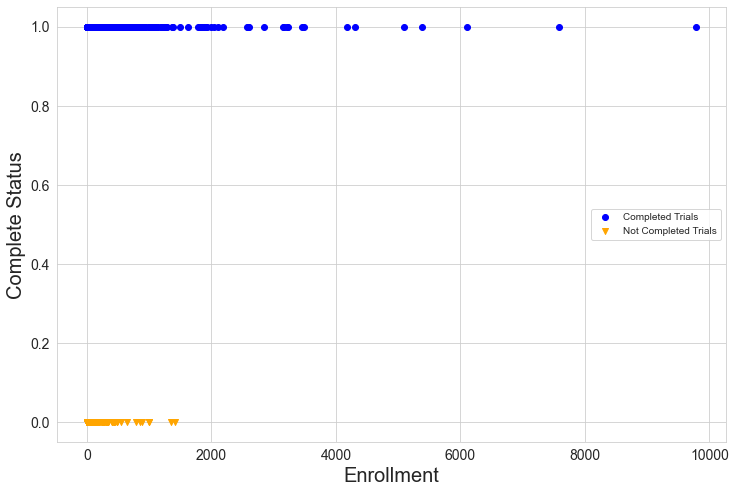

In [17]:
plt.figure(figsize=(12,8))

clTrials_train_completed = clTrials_train[clTrials_train["Status"]=="Completed"]
clTrials_train_not_completed = clTrials_train[clTrials_train["Status"]!="Completed"]

plt.scatter(clTrials_train_completed["Enrollment"],
               clTrials_train_completed["Completed_Status"],color = 'b',label = "Completed Trials")

plt.scatter(clTrials_train_not_completed["Enrollment"],
               clTrials_train_not_completed["Completed_Status"],color = 'orange',marker = 'v',label = "Not Completed Trials")


plt.legend(loc = "center right")
plt.xlabel("Enrollment", fontsize=20)
plt.ylabel("Complete Status", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

We modify the df so that enrollment <= 1500. Because, it seems that if it is >1500, then it is completed.


So, in our model, first we should check whether enrollment > 1500.

For a model, if we don't use enrollment, then the original clTrials can be used.

In [18]:
clTrials_completed = clTrials[clTrials["Status"]=="Completed"]
clTrials_not_completed = clTrials[clTrials["Status"]!="Completed"]

In [19]:
clTrials_not_completed

,Rank,Title,Status,Study Results,Conditions,Interventions,Outcome Measures,Gender,Age,Phases,...,Treatment (Purpose),Fed Funding,Industry Funding,Female,Male,Metastatic,Phases Num,Completed_Status,Minimum Age,Hospital
8337,8338,Antineoplaston Therapy in Treating Patients Wi...,Terminated,Has Results,Multiple Myeloma,Drug: Antineoplaston therapy (Atengenal + Astu...,Number of Participants With Objective Response...,All,"18 Years to 99 Years (Adult, Older Adult)",Phase 2,...,1,0,0,0,0,0,3.0,0,18,0
8340,8341,SCH 54031 PEG12000 Interferon Alfa-2b (PEG Int...,Terminated,Has Results,Melanoma,Biological: PEG-Intron|Biological: INTRON A,Progression-free Survival (PFS)|Overall Survival,All,"18 Years to 70 Years (Adult, Older Adult)",Phase 2|Phase 3,...,1,1,0,0,0,0,4.0,0,18,0
8341,8342,Polyethylene Glycol Interferon Alfa-2b (PEG In...,Terminated,Has Results,Chronic Myelogenous Leukemia,Biological: Pegylated interferon alfa-2b|Biolo...,Number of Participants With Cytogenetic Respon...,All,"18 Years to 70 Years (Adult, Older Adult)",Phase 2|Phase 3,...,1,1,0,0,0,0,4.0,0,18,0
8345,8346,Monoclonal Antibody Therapy in Treating Patien...,Terminated,Has Results,Colorectal Cancer,Biological: monoclonal antibody hu3S193,Number of Patients With Dose-limiting Toxiciti...,All,"18 Years and older (Adult, Older Adult)",Phase 1,...,1,0,0,0,0,0,1.0,0,18,0
8346,8347,Antibody Therapy in Treating Patients With Ref...,Terminated,Has Results,Leukemia|Lymphoma,Biological: bispecific antibody 4G7xH22|Biolog...,Clinical Toxicity|Determine the Maximum Tolera...,All,"18 Years to 120 Years (Adult, Older Adult)",Phase 1,...,1,0,1,0,0,0,1.0,0,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11185,11186,Human IL-15 (rhIL-15) and Obinutuzumab for Rel...,Terminated,Has Results,Leukemia|Lymphocytic|Chronic|B-Cell,Drug: rhIL-15|Biological: Obinutuzumab,Number of Treatment-emergent Adverse Events (A...,All,"18 Years and older (Adult, Older Adult)",Phase 1,...,1,0,1,0,0,0,1.0,0,18,1
11186,11187,"BN-Brachyury, Entinostat, Adotrastuzumab Emtan...",Terminated,Has Results,Breast Cancer|Triple Negative Breast Cancer|HE...,Biological: Brachyury-TRICOM|Drug: Entinostat|...,Overall Response (Partial Response + Complete ...,All,"18 Years and older (Adult, Older Adult)",Phase 1,...,1,0,1,0,0,1,1.0,0,18,1
11187,11188,Optune Device - TT Field Plus Nivolumab and Ip...,Terminated,Has Results,Melanoma With Brain Metastasis,Device: Optune|Biological: Nivolumab|Biologica...,Intracranial Progression-free Survival|Overall...,All,"18 Years and older (Adult, Older Adult)",Phase 2,...,1,1,0,0,0,0,3.0,0,18,1
11193,11194,Immune Checkpoint Inhibitor M7824 and the Immu...,Terminated,Has Results,Histologically or Cytologically Confirmed Panc...,Drug: M7824|Drug: M9241|Radiation: SBRT,Recommended Phase 2 Dose (RP2D) of NHS-IL12 (M...,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,...,1,0,1,0,0,1,2.0,0,18,1


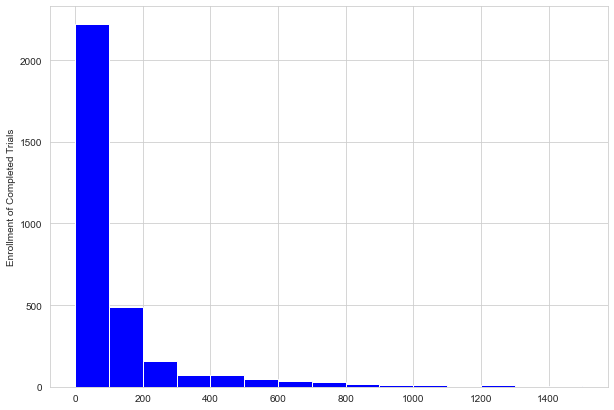

In [20]:
a = np.array(clTrials_completed["Enrollment"])
 
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500],color = 'b')

plt.ylabel("Enrollment of Completed Trials")
 
# Show plot
plt.show()

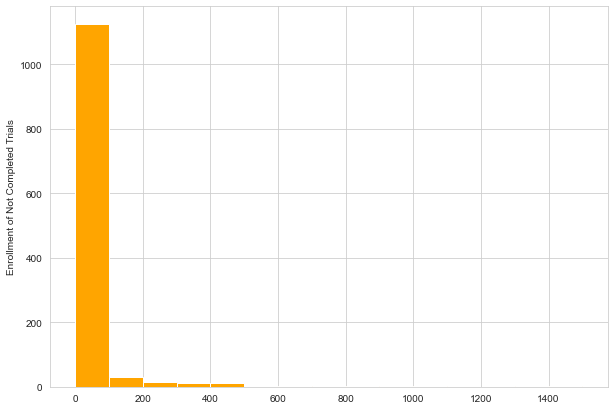

In [21]:
a = np.array(clTrials_not_completed["Enrollment"])
 
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500],color = 'orange')

plt.ylabel("Enrollment of Not Completed Trials")
# Show plot
plt.show()

In [22]:
max(clTrials_not_completed["Enrollment"])

4509

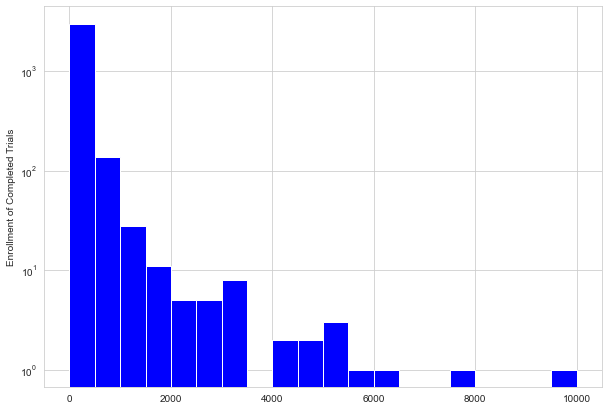

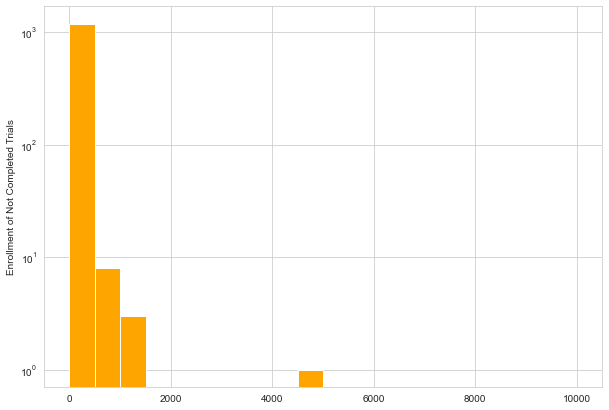

In [23]:
a1 = np.array(clTrials_completed["Enrollment"])
 
# Creating histogram
fig, a1x = plt.subplots(figsize =(10, 7))
#a1x.hist(a1, bins = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500],color = 'b')
a1x.hist(a1, bins = [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000],color = 'b')
plt.yscale("log")
plt.ylabel("Enrollment of Completed Trials")


a2 = np.array(clTrials_not_completed["Enrollment"])
 
# Creating histogram
fig, a2x = plt.subplots(figsize =(10, 7))
#a2x.hist(a2, bins = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,2000],color = 'orange')
a2x.hist(a2, bins = [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000],color = 'orange')


 
# Show plot

plt.ylabel("Enrollment of Not Completed Trials")
plt.yscale("log")
plt.show()

In [24]:
#Here we introduce the modified data.

clTrials_train_modified = clTrials_train[clTrials_train['Enrollment'] <= 1500]
clTrials_test_modified = clTrials_test[clTrials_test['Enrollment'] <= 1500]

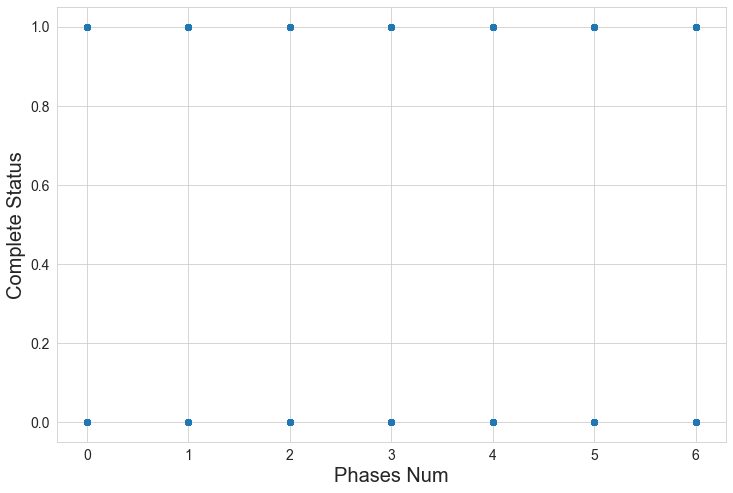

In [25]:
# We know this is stupid :))

plt.figure(figsize=(12,8))

plt.scatter(clTrials_train["Phases Num"],
               clTrials_train["Completed_Status"])

plt.xlabel("Phases Num", fontsize=20)
plt.ylabel("Complete Status", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

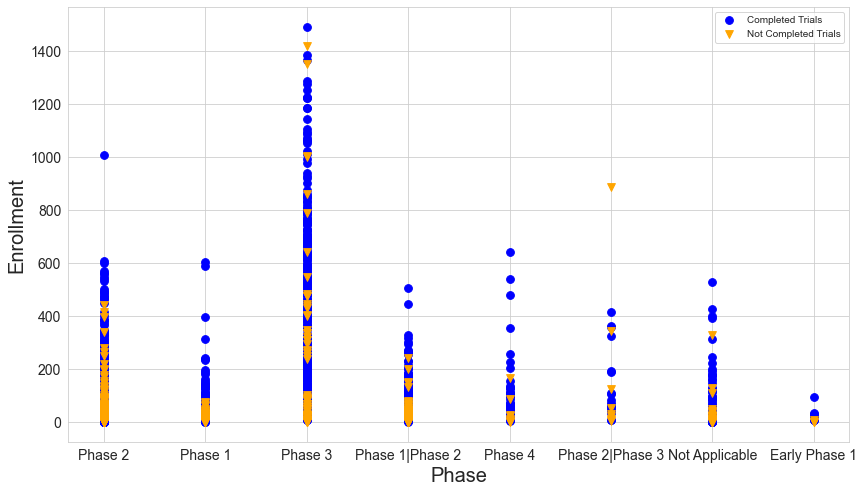

In [26]:
plt.figure(figsize=(14,8))

# plt.scatter(clTrials_train["Phases Num"],
#                clTrials_train["Enrollment"])


plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status=='Completed']['Phases'],
            clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Enrollment'],
            c='blue',
            s=60,
            label="Completed Trials")

plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Phases'],
            clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Enrollment'],
            c='orange',
            s=60,
            marker='v',
            label="Not Completed Trials")


plt.xlabel("Phase", fontsize=20)
plt.ylabel("Enrollment", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc = "upper right")

plt.show()

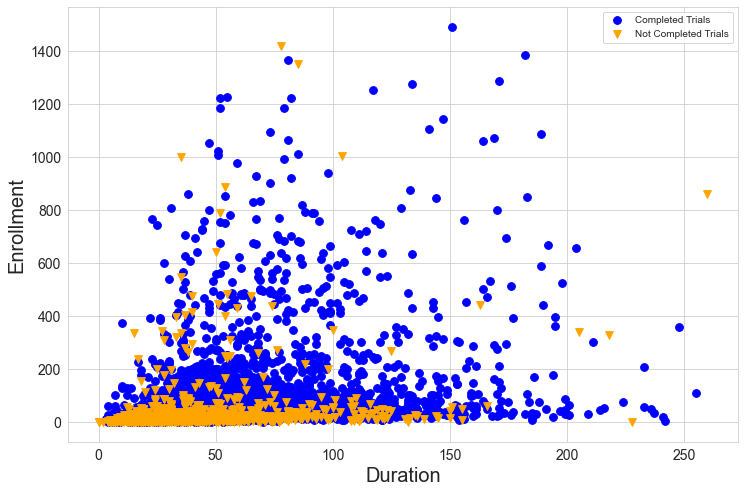

In [27]:
plt.figure(figsize=(12,8))

# plt.scatter(clTrials_train["Phases Num"],
#                clTrials_train["Enrollment"])


plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status=='Completed']['Study Duration (months)'],
            clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Enrollment'],
            c='blue',
            s=60,
            label="Completed Trials")

plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Study Duration (months)'],
            clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Enrollment'],
            c='orange',
            s=60,
            marker='v',
            label="Not Completed Trials")


plt.xlabel("Duration", fontsize=20)
plt.ylabel("Enrollment", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc = "upper right")

plt.show()

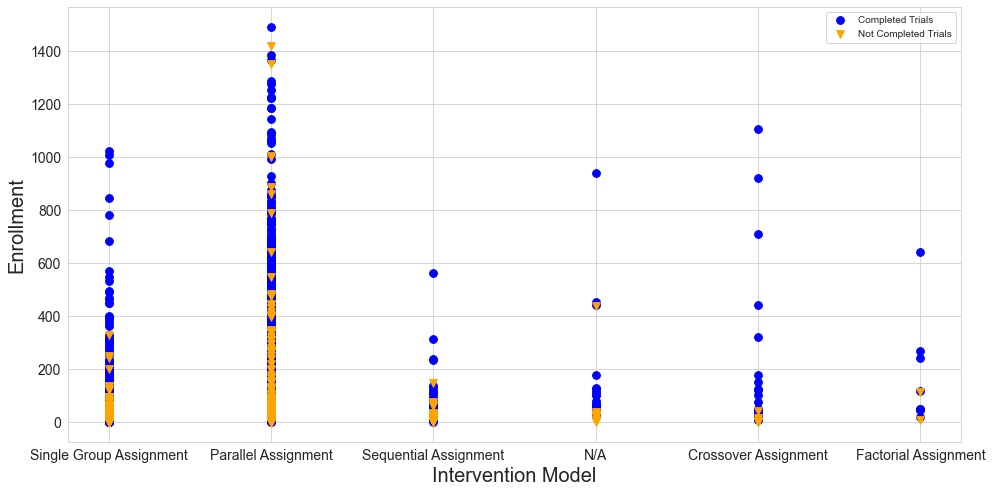

In [28]:
plt.figure(figsize=(16,8))

# plt.scatter(clTrials_train["Phases Num"],
#                clTrials_train["Enrollment"])


plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status=='Completed']['Intervention_model_string'],
            clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Enrollment'],
            c='blue',
            s=60,
            label="Completed Trials")

plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Intervention_model_string'],
            clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Enrollment'],
            c='orange',
            s=60,
            marker='v',
            label="Not Completed Trials")


plt.xlabel("Intervention Model", fontsize=20)
plt.ylabel("Enrollment", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc = "upper right")

plt.show()

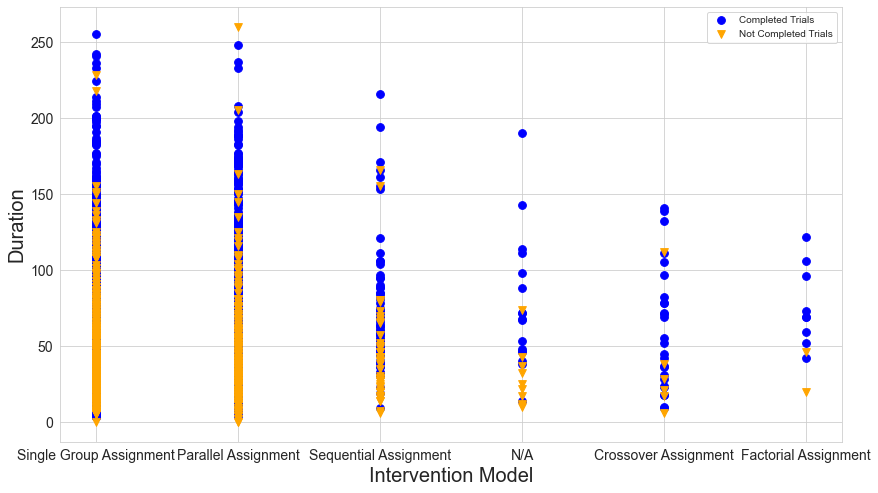

In [29]:
# NOT MODIFIED has been used here!

plt.figure(figsize=(14,8))


# plt.scatter(clTrials_train["Phases Num"],
#                clTrials_train["Enrollment"])


plt.scatter(clTrials_train.loc[clTrials_train.Status=='Completed']['Intervention_model_string'],
            clTrials_train.loc[clTrials_train.Status =='Completed']['Study Duration (months)'],
            c='blue',
            s=60,
            label="Completed Trials")

plt.scatter(clTrials_train.loc[clTrials_train.Status !='Completed']['Intervention_model_string'],
            clTrials_train.loc[clTrials_train.Status !='Completed']['Study Duration (months)'],
            c='orange',
            s=60,
            marker='v',
            label="Not Completed Trials")


plt.xlabel("Intervention Model", fontsize=20)
plt.ylabel("Duration", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc = "upper right")

plt.show()

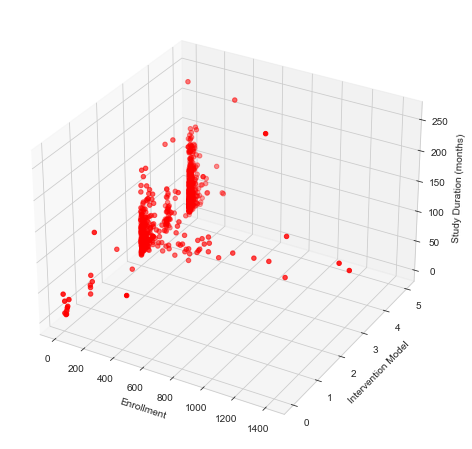

In [30]:
plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')



# Data for three-dimensional scattered points
zdata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Study Duration (months)']
xdata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Enrollment']
ydata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Intervention Model']
 
# plt.xlabel("Enrollment")
# plt.ylabel("Intervention Model")
# plt.zlabel("Study Duration (months)")
ax.set_xlabel('Enrollment')
ax.set_ylabel('Intervention Model')
ax.set_zlabel('Study Duration (months)')
ax.scatter3D(xdata, ydata, zdata, color="r")

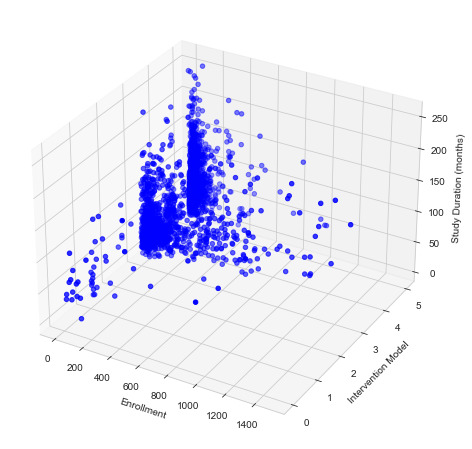

In [31]:
plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
zdata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Study Duration (months)']
xdata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Enrollment']
ydata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Intervention Model']
ax.set_xlabel('Enrollment')
ax.set_ylabel('Intervention Model')
ax.set_zlabel('Study Duration (months)')
ax.scatter3D(xdata, ydata, zdata, color="b");

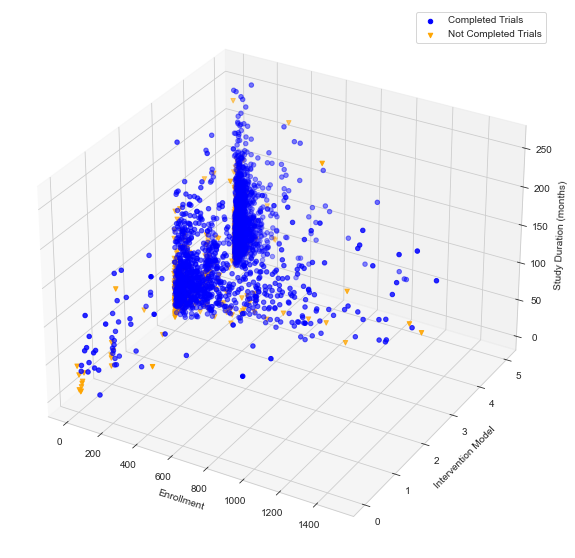

In [32]:
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
zdata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Study Duration (months)']
xdata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Enrollment']
ydata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Intervention Model'] 
ax.scatter3D(xdata, ydata, zdata, color="b",label = "Completed Trials");

Zdata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Study Duration (months)']
Xdata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Enrollment']
Ydata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Intervention Model']


ax.set_xlabel('Enrollment')
ax.set_ylabel('Intervention Model')
ax.set_zlabel('Study Duration (months)') 
ax.scatter3D(Xdata, Ydata, Zdata, color="orange",marker = "v",label = "Not Completed Trials");
ax.legend(loc = "upper right")


## Use k-nearest neighbor model.

In [50]:
def knn_pred(k):
    a = KNeighborsClassifier(k)
    a.fit(clTrials_train_modified[['Study Duration (months)', 'Enrollment', 'Intervention Model']],clTrials_train_modified.Completed_Status)
    return a.predict(clTrials_test_modified[['Study Duration (months)', 'Enrollment', 'Intervention Model']])

# def knn_fit(k):
#     return knn(k).fit(clTrials_train_modified[['Study Duration (months)', 'Enrollment', 'Intervention Model']],
#            clTrials_train_modified.Completed_Status)
# a = knn(27)
# b = knn_fit(27)

In [51]:
knn_pred(27)

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [52]:
TEST = list(clTrials_test_modified['Completed_Status'])

def knn_err(k):
    c=0
    for i in range(len(knn_pred(k))):
        if knn_pred(k)[i] == TEST[i]:
            c = c+1
    return c/len(knn_pred(k))
knn_err(27)

0.8256880733944955

In [53]:
knn_err(19)

0.8279816513761468

In [54]:
inp = [2*i+1 for i in range(18)]
out = [knn_err(k) for k in inp]

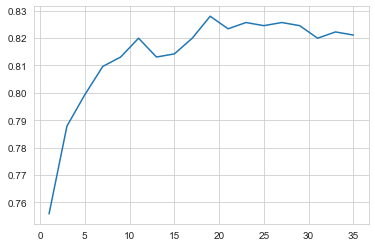

In [55]:
plt.plot(inp,out)

In [56]:
# knn with one feature changed
def knn1_pred(k):
    a = KNeighborsClassifier(k)
    a.fit(clTrials_train_modified[['Study Duration (months)', 'Enrollment', 'Minimum Age']],clTrials_train_modified.Completed_Status)
    return a.predict(clTrials_test_modified[['Study Duration (months)', 'Enrollment', 'Minimum Age']])
def knn1_err(k):
    c=0
    for i in range(len(knn1_pred(k))):
        if knn1_pred(k)[i] == TEST[i]:
            c = c+1
    return c/len(knn1_pred(k))


In [57]:
knn1_err(19)

0.823394495412844

In [58]:
inp = [2*i+1 for i in range(18)]
out = [knn1_err(k) for k in inp]

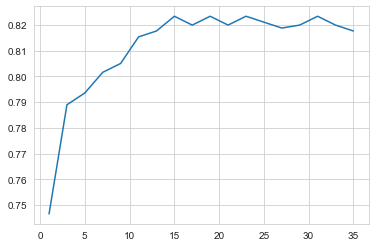

In [59]:
plt.plot(inp,out)

In [60]:
out

[0.7465596330275229,
 0.7889908256880734,
 0.7935779816513762,
 0.801605504587156,
 0.805045871559633,
 0.8153669724770642,
 0.8176605504587156,
 0.823394495412844,
 0.819954128440367,
 0.823394495412844,
 0.819954128440367,
 0.823394495412844,
 0.8211009174311926,
 0.8188073394495413,
 0.819954128440367,
 0.823394495412844,
 0.819954128440367,
 0.8176605504587156]

In [66]:
# Function that applies knn to k neighbours with features p,q,r
def knn_for_three_features_pred(k,p,q,r):
    a = KNeighborsClassifier(k)
    a.fit(clTrials_train_modified[[p, q, r]],clTrials_train_modified.Completed_Status)
    return a.predict(clTrials_test_modified[[p, q, r]])
def knn_for_three_features_err(k,p,q,r):
    c=0
    for i in range(len(knn_for_three_features_pred(k,p,q,r))):
        if knn_for_three_features_pred(k,p,q,r)[i] == TEST[i]:
            c = c+1
    return c/len(knn_for_three_features_pred(k,p,q,r))

In [68]:
# For graphing the number of neighbours for knn versus error
inp = [2*i+1 for i in range(18)]
def graph(p,q,r):
    out = [knn_for_three_features_err(k,p,q,r) for k in inp]
    plt.plot(inp,out)

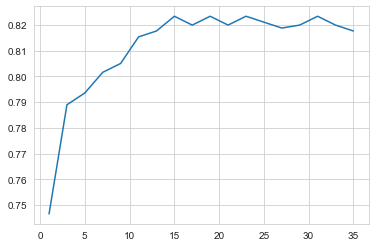

In [69]:
graph("Enrollment","Study Duration (months)","Minimum Age")

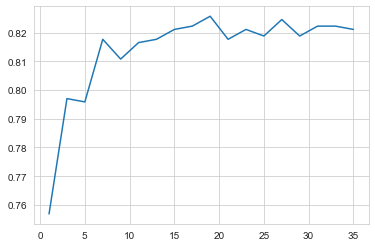

In [70]:
graph("Enrollment","Study Duration (months)","Hospital")

In [73]:
# knn with one feature changed
def knn0_pred(k):
    a = KNeighborsClassifier(k)
    a.fit(clTrials_train_modified[['Study Duration (months)', 'Enrollment']],clTrials_train_modified.Completed_Status)
    return a.predict(clTrials_test_modified[['Study Duration (months)', 'Enrollment']])
def knn0_err(k):
    c=0
    for i in range(len(knn0_pred(k))):
        if knn0_pred(k)[i] == TEST[i]:
            c = c+1
    return c/len(knn0_pred(k))


In [74]:
knn0_err(19)

0.823394495412844

### With k-nearest approach, where k=5, we get 80% accuracy. With k = 27, we get ~83%
### To try with different k values, we should first clean/rearrange the code first.

## Now use Decision Tree Classifier

In [ ]:
tree_clf = DecisionTreeClassifier()